In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from IPython.display import clear_output

In [2]:
"""Here we download the subset of the dataset, using the script written 
in the shell file downloadSubset3.sh"""

%%capture
!bash ../input/eeg-downloader-sh/downloadSubset3.sh

import os
train_normal_file_names = []
train_abnormal_file_names = []
test_file_names = []
test_abnormal_file_names = []
test_normal_file_names = []

for dirname, _, filenames in os.walk('./isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v2.0.0/edf/train/normal'):
    for filename in filenames:
        train_normal_file_names.append(os.path.join(dirname, filename))
for dirname, _, filenames in os.walk('./isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v2.0.0/edf/train/abnormal'):
    for filename in filenames:
        train_abnormal_file_names.append(os.path.join(dirname, filename))
for dirname, _, filenames in os.walk('./isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v2.0.0/edf/eval/normal'):
    for filename in filenames:
        test_normal_file_names.append(os.path.join(dirname, filename))
for dirname, _, filenames in os.walk('./isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v2.0.0/edf/eval/abnormal'):
    for filename in filenames:
        test_abnormal_file_names.append(os.path.join(dirname, filename))

!mkdir ./Data
!mkdir ./Data/abnormal/
!mkdir ./Data/normal/
!mkdir ./Data/abnormal/train/
!mkdir ./Data/normal/train/
!mkdir ./Data/abnormal/test/
!mkdir ./Data/normal/test/

for file_path in tqdm(train_normal_file_names):
    !mv $file_path ./Data/normal/train/
for file_path in tqdm(train_abnormal_file_names):
    !mv $file_path ./Data/abnormal/train/
for file_path in tqdm(test_normal_file_names):
    !mv $file_path ./Data/normal/test/
for file_path in tqdm(test_abnormal_file_names):
    !mv $file_path ./Data/abnormal/test/

In [4]:
!pip install mne
!pip install git+https://github.com/TNTLFreiburg/braindecode.git
clear_output()

## Training

In [13]:
from data_utils import data_loader

from train_loop import evaluate, kf_training, save_accuracies

from config import Config

config = Config()

X,y,test_X,test_y = data_loader(config)

(chronoNet_models, 
 train_accuracies, 
 valid_accuracies, 
 testset_X, 
 testset_y) = kf_training(X,y,test_X,test_y, model_name = 'chronoNet')
clear_output()

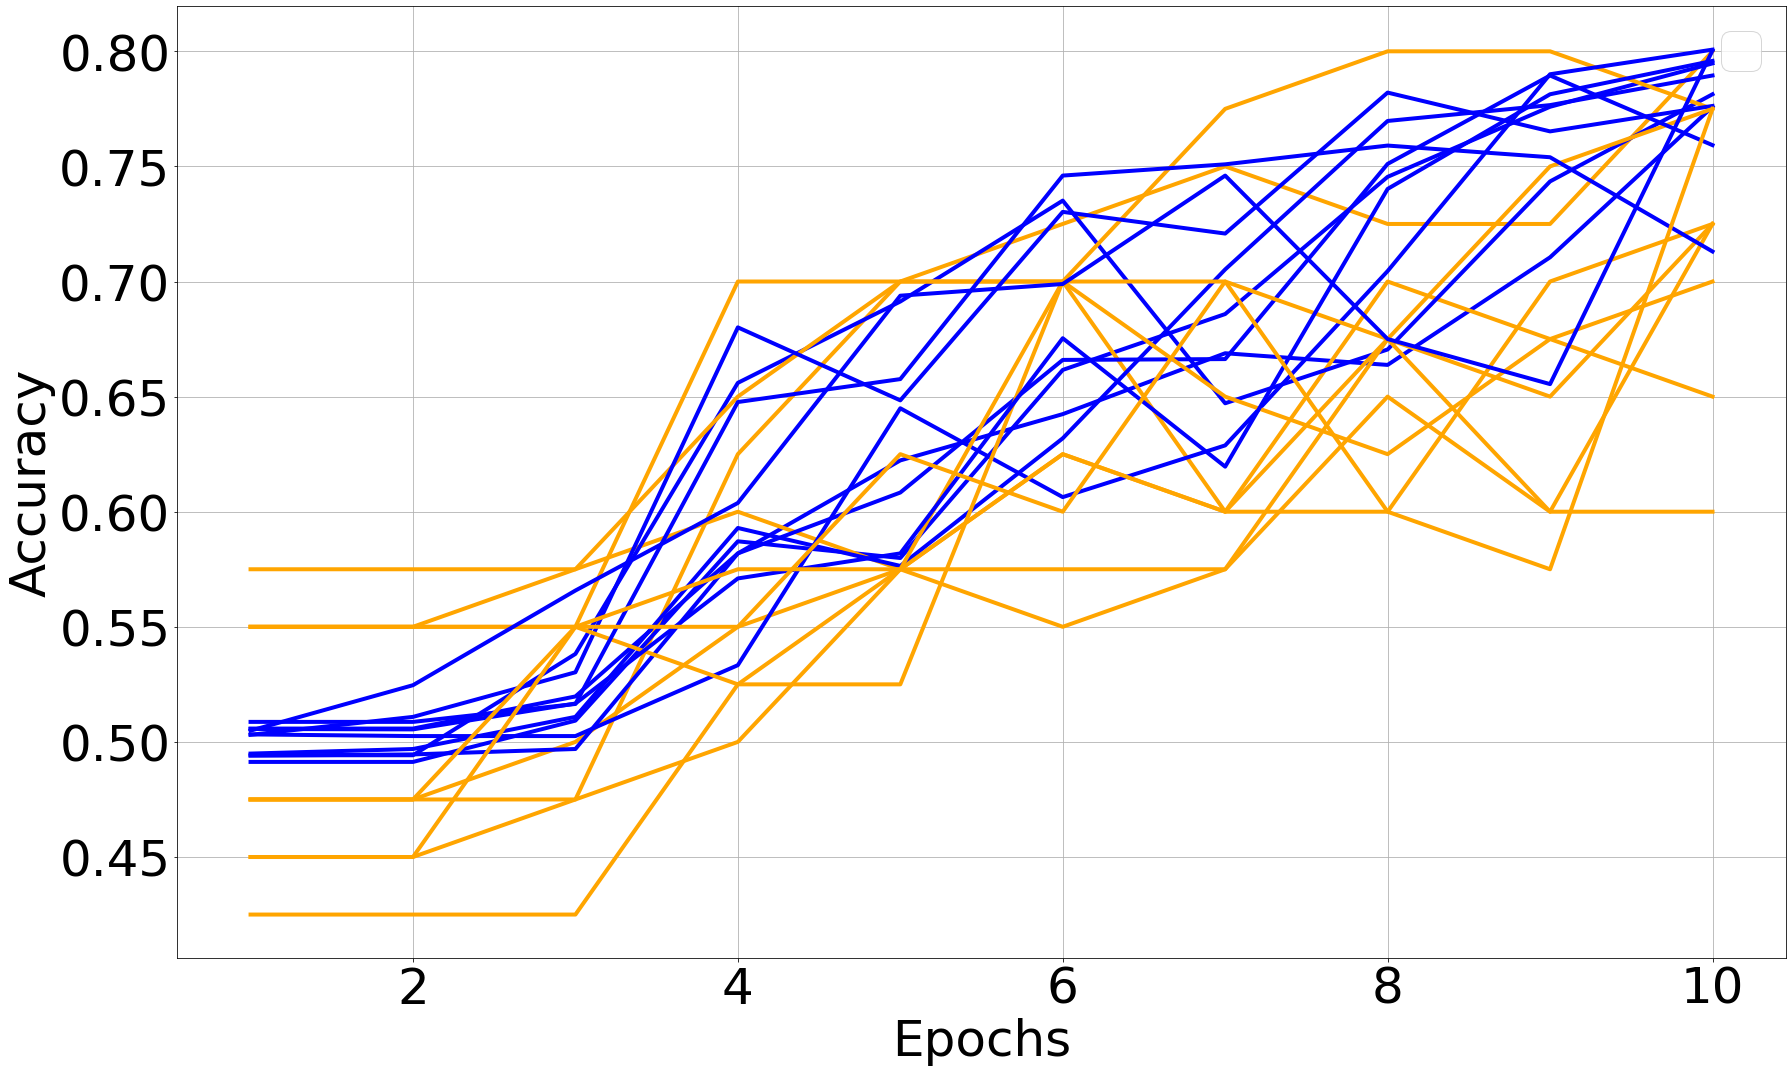

In [15]:
import matplotlib.pyplot as plt
import math
def make_plot():
    epochs = range(1, 11)
    xint = range(min(epochs)+1, math.ceil(max(epochs))+1, 2)

    colors = ["#0000FF", "#FFA500"]
    plt.figure(figsize=(25,15))
    for i in range(len(train_accuracies)):
        plt.plot(epochs, train_accuracies[i], linewidth=4, c="#0000FF")
        plt.plot(epochs, valid_accuracies[i], linewidth=4, c="#FFA500")
    plt.xlabel('Epochs', fontsize=50)
    plt.ylabel('Accuracy', fontsize=50)
    plt.legend(fontsize=50)
    plt.xticks(xint, fontsize=50)
    plt.yticks(fontsize=50)
    plt.grid()
    plt.tight_layout()
    plt.show()

make_plot()

### Evaluation on Test Data using spectral removing (Filtering frequencey band) and perturbation

In [37]:
perturbation_band_accuracies = save_accuracies(chronoNet_models, testset_X, testset_y, band_cut=False)
clear_output()

In [40]:
import json
jsonString = json.dumps(perturbation_band_accuracies)
with open ("./eval_test_results.json", "w") as jsonFile:
    jsonFile.write(jsonString)

In [51]:
from kruskal import kruskal_test
kruskal_test(perturbation_band_accuracies)

(7, 10)
delta : KruskalResult(statistic=1.2857142857142776, pvalue=0.25683925795785484)
theta : KruskalResult(statistic=0.0014296463506443735, pvalue=0.9698386414047825)
alpha : KruskalResult(statistic=0.09142857142856542, pvalue=0.7623688184698474)
mu : KruskalResult(statistic=0.0014296463506443735, pvalue=0.9698386414047825)
beta : KruskalResult(statistic=0.1428571428571388, pvalue=0.7054569861112774)
gamma : KruskalResult(statistic=0.005714285714276457, pvalue=0.939742989577122)


In [103]:
res = np.array(list(perturbation_band_accuracies.values()))
res = np.moveaxis(res, 0, 1)

In [108]:
df = pd.DataFrame(res)
df.columns = list(perturbation_band_accuracies.keys())
df

,no,delta,theta,alpha,mu,beta,gamma
0,0.693934,0.664062,0.693934,0.694853,0.693474,0.693934,0.694853
1,0.650735,0.649357,0.642004,0.640625,0.650276,0.649816,0.649816
2,0.678768,0.658088,0.658088,0.666360,0.673713,0.673254,0.677849
3,0.739430,0.696232,0.715533,0.738511,0.740349,0.738051,0.738511
4,0.686121,0.671415,0.686581,0.685202,0.679688,0.677849,0.678309
5,0.693474,0.672794,0.694853,0.692555,0.700368,0.684743,0.687960
6,0.648897,0.641544,0.650276,0.647978,0.649357,0.647978,0.649816
7,0.603860,0.597886,0.604779,0.603401,0.603401,0.604320,0.604320
8,0.581801,0.572610,0.581801,0.582261,0.580882,0.581342,0.582261
9,0.664982,0.648438,0.671415,0.662684,0.670956,0.664062,0.669577


In [110]:
bands = df.loc[:, df.columns != 'no']
raw = df.loc[:, df.columns == 'no']
raw = np.array(raw)

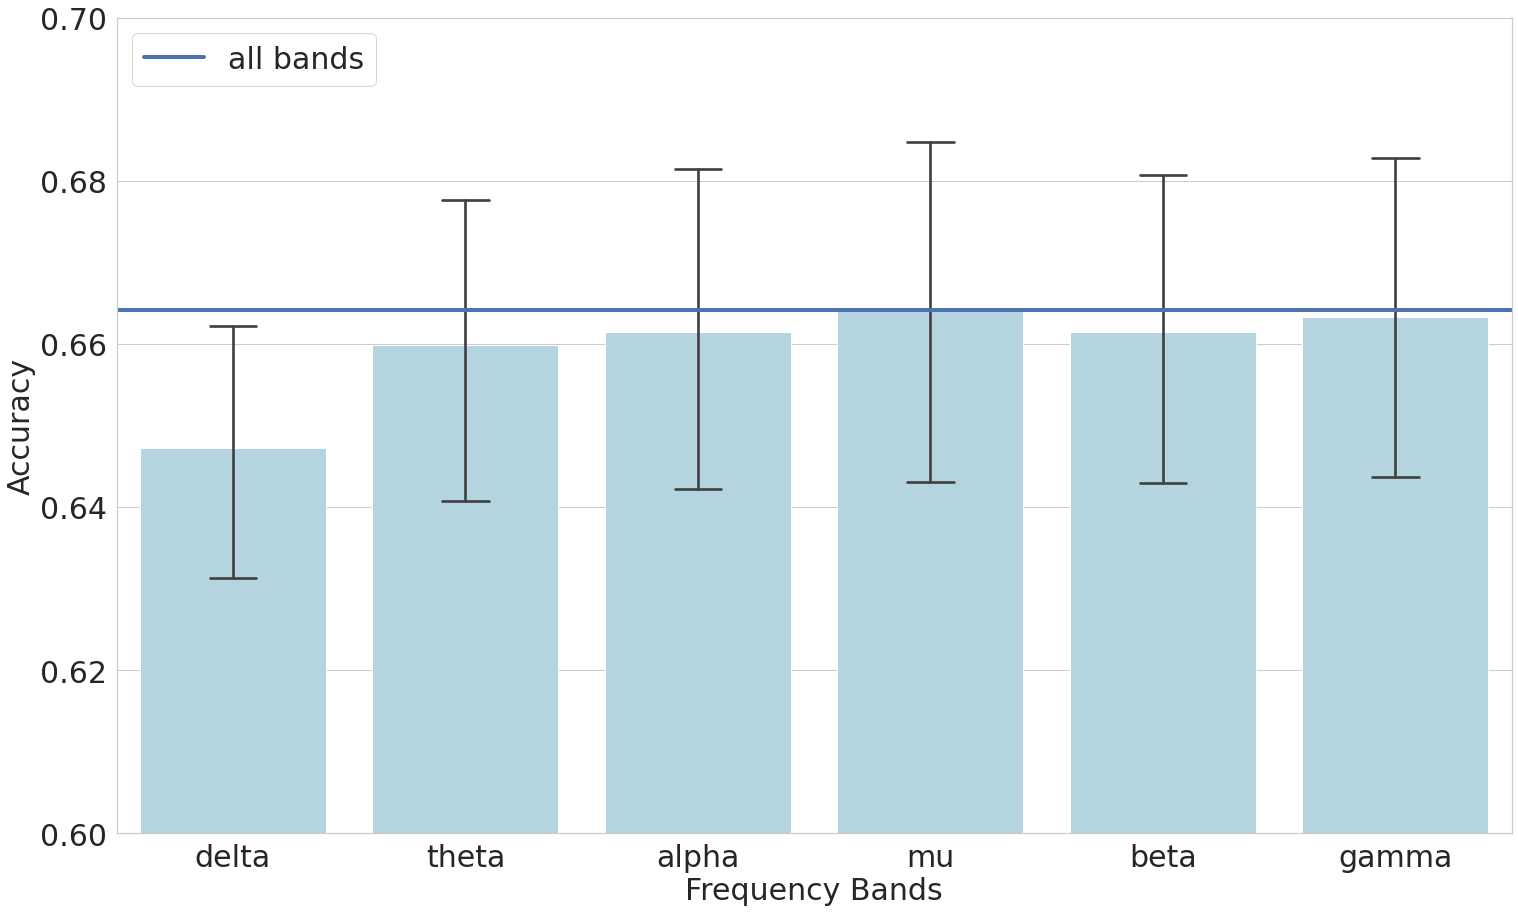

In [156]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(25,15))
sns.set_theme(style="whitegrid")
plt.ylim(0.6, 0.7)
plt.xlabel('Frequency Bands',fontsize=30)
plt.ylabel('Accuracy',fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
ax = sns.barplot(data=bands, estimator=np.mean, ci=85, capsize=.2, color='lightblue')
ax.axhline(y=np.mean(raw), linewidth=4, label='all bands')
plt.legend(loc="upper left",  prop={'size': 30})
plt.show()